In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from specutils import Spectrum1D
from specutils.fitting import find_lines_threshold, find_lines_derivative
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37141', '*x1dsum.fits'))

In [ ]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [ ]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [23]:
spectrum_header = [fits.getheader(file, ext=0) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [92]:
spectrum_header[0]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    3                                                  
FITS_VER= 'Definition of the Flexible Image Transport System (FITS) v4.0 &'     
CONTINUE  'https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf'      
FITS_SW = 'astropy.io.fits v6.1.0' / FITS file creation software                
ORIGIN  = 'Space Telescope Science Institute' / FITS file originator            
DATE    = '2025-03-13'         / Date this file was written                     
FILENAME= 'hst_12036_cos_v-ru-lupi_g130m-g160m_lbgj53_cspec.fits' / Name of this
IPPPSSOO= 'lbgj53  '           / IPPP or IPPPSS for product                     
TELESCOP= 'HST     '        

In [91]:
date = [header['DATE'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header]
instrument_filter = [header['OPT_ELEM'] for header in spectrum_header]

KeyError: "Keyword 'OPT_ELEM' not found."

In [25]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
lab_emission_lines = lines['lab_lambda']
transition_grouped_lines = lines.groupby("[nu', J']")

In [67]:
spectrum_x1d[0]

WAVELENGTH,FLUX,ERROR,SNR,EFF_EXPTIME
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,s
float32[59914],float32[59914],float32[59914],float32[59914],float32[59914]
1135.6062 .. 1795.7308,-9.243304e-17 .. 3.5043925e-14,8.496804e-16 .. 9.7835134e-15,-0.10878565 .. 3.5819366,1199.168 .. 1382.176


In [85]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [43]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [87]:
peaks , _ = find_peaks(x1d_flux, height=max(x1d_fluxerr.value)*2, distance=100)

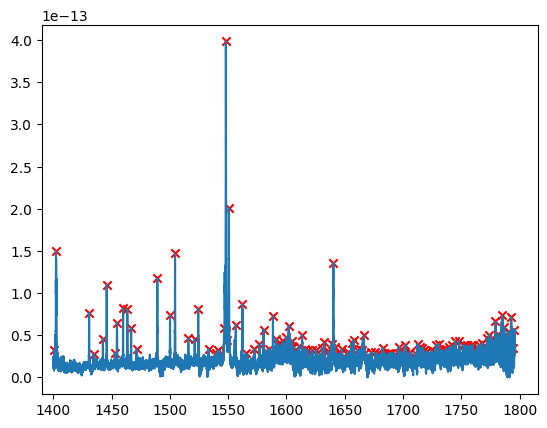

In [88]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [52]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

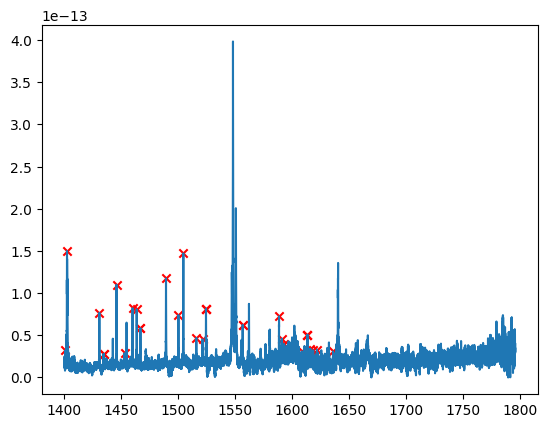

In [53]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [54]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

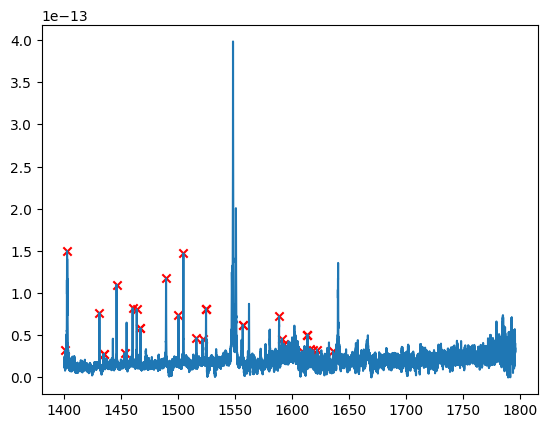

In [55]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [59]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [60]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[3,13]",(3–9)P(14),"[3,13]",1608.33,[1.7703417196286188e-14 cm2 erg / (Angstrom s)...,[3.3116178205840627e-15 cm2 erg / (Angstrom s)...,"[1606.56494140625 Angstrom, 1606.5772705078125..."
"[3,13]",(3–10)R(12),"[3,13]",1615.43,"[2.078932254752537e-14 cm2 erg / (Angstrom s),...",[2.9581416543324234e-15 cm2 erg / (Angstrom s)...,"[1614.133056640625 Angstrom, 1614.145385742187..."
"[4,13]",(4–11)R(12),"[4,13]",1613.99,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[3,16]",(3–7)R(15),"[3,16]",1513.99,[1.9793437112318284e-14 cm2 erg / (Angstrom s)...,[1.8945835805956376e-15 cm2 erg / (Angstrom s)...,"[1513.959716796875 Angstrom, 1513.972045898437..."
"[3,16]",(3–9)R(15),"[3,16]",1593.26,"[3.643838838518834e-14 cm2 erg / (Angstrom s),...","[3.618663240557247e-15 cm2 erg / (Angstrom s),...","[1591.036865234375 Angstrom, 1591.049194335937..."
"[3,16]",(3–10)R(15),"[3,16]",1621.12,[1.8693229405261462e-14 cm2 erg / (Angstrom s)...,[2.8322530766126475e-15 cm2 erg / (Angstrom s)...,"[1619.9132080078125 Angstrom, 1619.92553710937..."
"[4,4]",(4–9)P(5),"[4,4]",1526.55,[2.3042643639524518e-14 cm2 erg / (Angstrom s)...,"[2.075113618468078e-15 cm2 erg / (Angstrom s),...","[1522.4462890625 Angstrom, 1522.4586181640625 ..."
"[4,4]",(4–11)P(5),"[4,4]",1613.72,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[1,7]",(1–6)P(8),"[1,7]",1467.08,[2.2690731943126458e-14 cm2 erg / (Angstrom s)...,[1.8396350709995934e-15 cm2 erg / (Angstrom s)...,"[1464.8773193359375 Angstrom, 1464.88952636718..."


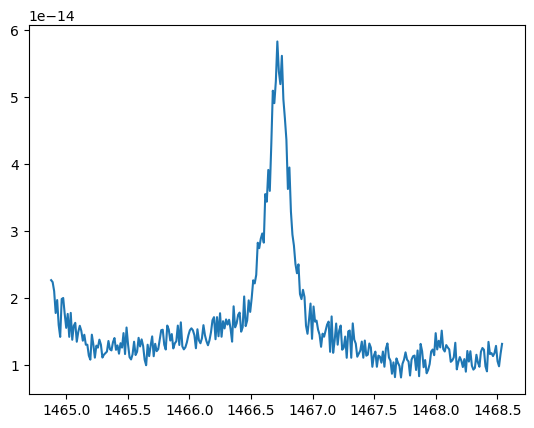

In [61]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [ ]:
#Keep units for future math
class spectrum():
    def __init__(self, files):
        """
        Initialize spectrum, unpack spectra into useable arrays
        files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))
        self.wavelength_units = u.AA
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            spectrum_header = fits.getheader(file, ext=0)
            spectrum_x1d = Table.read(file, hdu=1)
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])
            date = spectrum_header['DATE']
            instrument = spectrum_header['INSTRUME']
            try:
                instrument_filter = spectrum_header['OPT_ELEM']
            except KeyError:
                instrument_filter = spectrum_header['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date, 
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength, 
                       'flux': self.x1d_flux, 
                       'fluxerr':self.x1d_fluxerr}
            rows.append(pd.Series(df_data))
        self.spec_dfs = pd.DataFrame(rows)

    # def coadd_spectra(self):
    # """
    # Co-add spectra taken on the same date. This function will take in spectra 
    # (specific wavelength range or full), and return coadded spectra.
    # It does not group by date in this function.
    # """
    # Use specutils1d for coadding. basically the same as ULLYSES and HASP since x1dsum takes care of grating differences
    # spectra = Spectrum1D(spectral_axis = spectra_wl[x] * u.angstrom, flux = spectra_flux[x]*u.erg/u.s/u.cm**2/u.angstrom)
    # new_spectral_axis = np.sort(np.concatenate([spec.spectral_axis.value, spec.spectral_axis.to_value(spec.spectral_axis.unit)]) * spec.spectral_axis.unit)
    # resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    # new_spec_1 = resampler(spec, new_spectral_axis)
    # new_spec2 = resampler(spectra, new_spectral_axis)
    # spec = new_spec_1 + new_spec2
    
    # def H2lines_fromspectrum(self, file_idx):
        

In [4]:
x1dsum_spectra = spectrum(spectrum_files)